In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from time import time
from IPython.display import clear_output
%matplotlib inline

In [2]:
df = pd.read_csv('raw_photon_dataATL03_20181028022213.txt', sep = ' ')
df.columns = ['','','','elev,','distance']
df = df[['elev,','distance']]
# df = df[(df['distance']>160000) & (df['distance']<165000)] #change range
df.reset_index(inplace = True)

C:\Users\Benji\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]
C:\Users\Benji\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


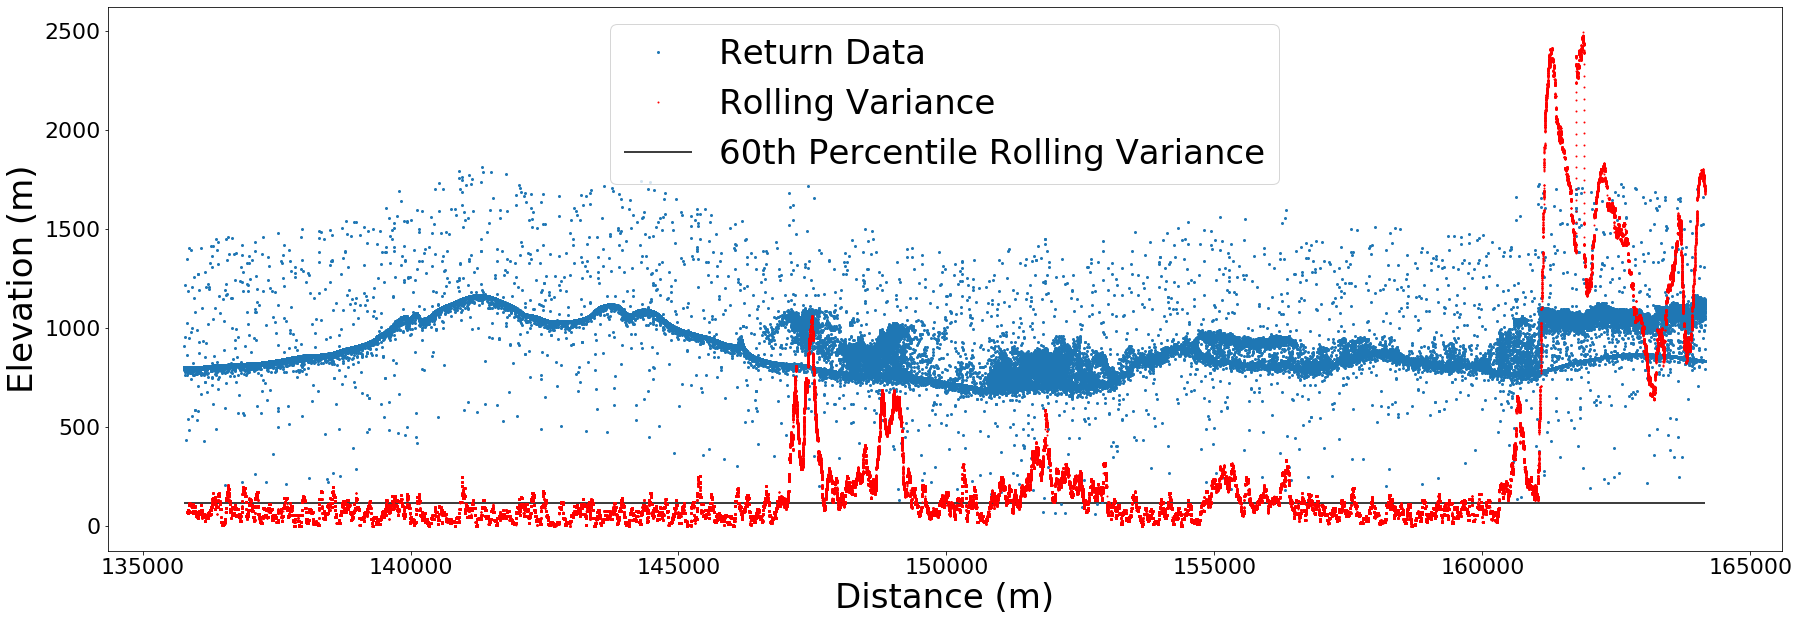

In [3]:
fig, ax = plt.subplots(1,1,figsize = (30,10))
rolling_var = df['elev,'].rolling(window = 1000).var()/10
ax.plot(df['distance'], df['elev,'],'o', markersize = 2, label = 'Return Data')
ax.hlines(xmin = np.min(df['distance']), xmax = np.max(df['distance']), y=np.percentile(rolling_var.dropna(), 60), color = 'black', label = '60th Percentile Rolling Variance')
ax.plot(df['distance'], rolling_var, '.',color = 'red', markersize = 2, label = 'Rolling Variance')
ax.legend(fontsize=24)
ax.set_ylabel('Elevation')
ax.set_xlabel('Distance')
ax.set_xlabel('Distance (m)', fontsize = 34)
ax.set_ylabel('Elevation (m)', fontsize = 34)
ax.legend(fontsize = 34)
ax.tick_params(labelsize=22)
plt.savefig('RollingVariance.png');


C:\Users\Benji\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]


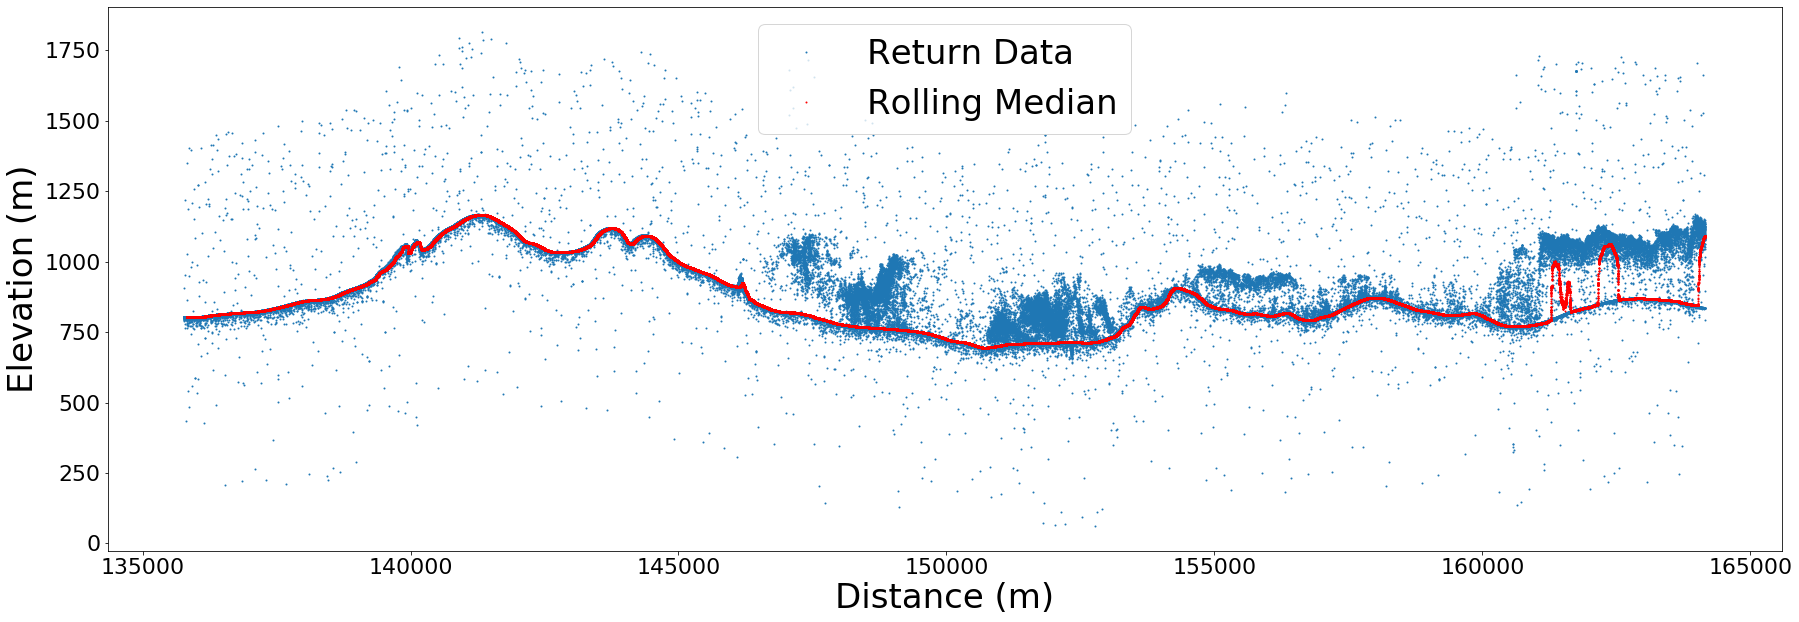

In [4]:
# df = df[(df['distance']>160000)]
fig, ax = plt.subplots(1,1,figsize = (30,10))
rolling_var = df['elev,'].rolling(window = 1000).median()
ax.plot(df['distance'], df['elev,'],'o', markersize = 1, label = 'Return Data')
ax.plot(df['distance'], rolling_var, '.',color = 'red', markersize = 2, label = 'Rolling Median')
ax.legend(fontsize=24)
ax.set_ylabel('Elevation')
ax.set_xlabel('Distance')
ax.set_xlabel('Distance (m)', fontsize = 34)
ax.set_ylabel('Elevation (m)', fontsize = 34)
ax.legend(fontsize = 34)
ax.tick_params(labelsize=22)
plt.savefig('RollingMedian.png');


In [5]:
def responsibility(mus, var, pi, df, x_param, y_param):
    class1 = np.array(stats.multivariate_normal.pdf(x = df[[x_param, y_param]], mean = mus[0], cov = var[0]))*pi[0]
    class2 = np.array(stats.multivariate_normal.pdf(x = df[[x_param, y_param]], mean = mus[1], cov = var[1]))*pi[1]
    total = np.array([class1, class2])
    maxs = np.argmax(total, axis =0)
    dicts = {'elev,':df[x_param], 'distance':df[y_param], 'class':maxs}
    return pd.DataFrame(dicts)

In [6]:
def EM(df, n_iter, x_param,y_param):   
    
    if len(df)%2 ==0:
        df= df.sample(len(df)-1)
        df.reset_index(drop = True, inplace = True)
        
    X = np.array(df[x_param])
    Y = np.array(df[y_param])
        
    mu1= df[df[y_param] == np.min(df[y_param])][[x_param,y_param]].values[0]
#     mu1= df[df[y_param] == np.median(df[y_param])][[x_param,y_param]].values[0]

    mu2 = df[df[y_param] == np.max(df[y_param])][[x_param,y_param]].values[0]
    
    var1 = np.cov(df[x_param].values, df[y_param].values)
    var2 = np.cov(df[x_param].values, df[y_param].values)
    
    pi = 0.50
    p_class1 = 1-pi
    p_class2 = pi


    for _ in range(n_iter): #100 steps is fine; or a tolerance check. 
        #ESTEP
        p_data_given_class1 = np.array(stats.multivariate_normal.pdf(x=df[[x_param, y_param]].values, mean=mu1, cov=var1) )
        p_data_given_class2 = np.array(stats.multivariate_normal.pdf(x=df[[x_param, y_param]].values, mean=mu2, cov=var2) )

        p_class1_given_data = p_data_given_class1*p_class1
        p_class2_given_data = p_data_given_class2*p_class2
        summ = p_class1_given_data + p_class2_given_data
        p_class1_given_data = p_class1_given_data / summ
        p_class2_given_data = p_class2_given_data / summ
        # Maximization step:
        n_class1 = np.sum(p_class1_given_data)
        n_class2 = np.sum(p_class2_given_data)

        pi = n_class2/len(X)
        p_class1 = 1-pi
        p_class2 = pi

        mu1x = (1/n_class1)*np.sum(p_class1_given_data*X)
        mu1y = (1/n_class1)*np.sum(p_class1_given_data*Y)
        mu2x = (1/n_class2)*np.sum(p_class2_given_data*X)
        mu2y = (1/n_class2)*np.sum(p_class2_given_data*Y)
        
        mu1=[mu1x, mu1y]
        mu2=[mu2x, mu2y]
        
        
        var1xx = (1/n_class1)*np.sum(p_class1_given_data*((X-mu1x)**2))
        var1yy = (1/n_class1)*np.sum(p_class1_given_data*((Y-mu1y)**2))
        var1xy = (1/n_class1)*np.sum(p_class1_given_data*((X-mu1x)*(Y-mu1y)))
        var2xx = (1/n_class2)*np.sum(p_class2_given_data*((X-mu2x)**2)) 
        var2yy = (1/n_class2)*np.sum(p_class2_given_data*((Y-mu2y)**2))
        var2xy = (1/n_class2)*np.sum(p_class2_given_data*((X-mu2x)*(Y-mu2y)))
        
        var1=[[var1xx, var1xy],[var1xy,var1yy]]
        var2=[[var2xx, var2xy],[var2xy,var2yy]]
        
    return [mu1, mu2], [var1, var2], [p_class1, p_class2]


In [9]:
def find_ground_in_path_window(df, x_param, y_param,n_windows, n_iter): 
    rolling_var = df[y_param].rolling(window = 1000).var()
    cutoff = np.percentile(rolling_var.dropna(), 60)
    df_gmm= pd.DataFrame()
    cutoffs = []
    ranges = np.linspace(np.min(df[x_param]), np.max(df[x_param]), n_windows)
    for i in range(len(ranges)-1):
        temp = df.loc[(df[x_param]>=ranges[i]) & (df[x_param]<ranges[i+1])]
        mus, var, ps = EM(temp, n_iter, x_param, y_param) 
        df_gmm = df_gmm.append( responsibility(mus, var, ps, temp,x_param, y_param))
    
    zero = df_gmm[df_gmm['class'] == 0]
    print(len(zero))
    one= df_gmm[df_gmm['class']== 1]
    print(len(one))
    fig, ax=plt.subplots(1,1,figsize =(40,10))
    ax.plot(one[y_param].values, one[x_param].values, 'o',color='purple',markersize = 5, label = 'Cloud')
    ax.plot(zero[y_param].values, zero[x_param].values,'o', color='orange',markersize = 5, label = 'Ground')
    ax.set_xlabel('Distance (m)', fontsize = 34)
    ax.set_ylabel('Elevation (m)', fontsize = 34)
    ax.legend(fontsize = 34)
    ax.tick_params(labelsize=22)

340755
91344


C:\Users\Benji\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


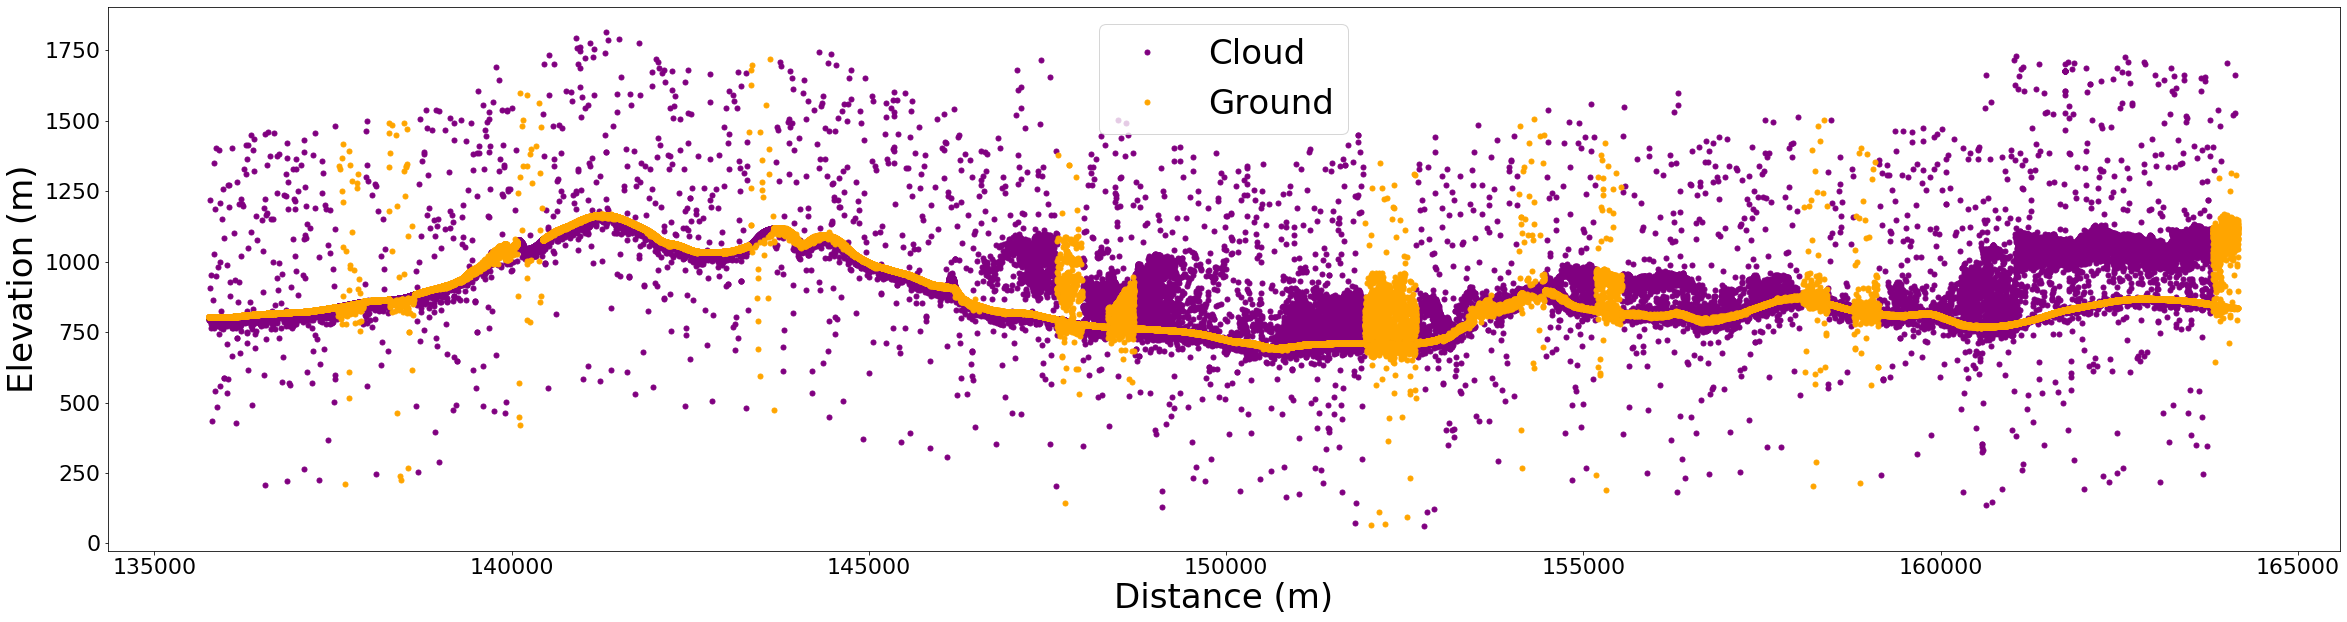

In [10]:
find_ground_in_path_window(df, 'distance', 'elev,', 80, 10)